<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code

In [160]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns

from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
def loadfile(filepath):
    img = io.imread(filepath, as_gray=True)
    img = np.array(img).astype(np.int32)
    txtfile= filepath.split('.')[0]+'.txt'
    with open(txtfile,'r') as txt_file:
        txt = txt_file.read()
        del txt_file
        txt=txt.split('\n')
        txt=txt[1:-1]
        sem_dict = {}
        for row in txt:
            row = row.split('=')
            sem_dict.update({row[0]:  row[1]}) 
        width, height = sem_dict['DataSize'].split('x')
        width, height = int(width), int(height)
        if height == 1920:
            img = img[0:1780,0:2560]
            height = 1780
        pixelsize = float(sem_dict['PixelSize'])
        print('FILE NAME:',sem_dict['ImageName'])
        print('DATE:',sem_dict['Date'] )   
        print('IMAGE SIZE [pixels]:', width,'x',height, ) 
        print('PIXEL SIZE [nm]:', sem_dict['PixelSize'],)

        print('IMAGE SIZE [nm]:', 
            round(width*float(sem_dict['PixelSize']),0), 
            'x',
            round(height*float(sem_dict['PixelSize']),0))
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,vmax=255, cmap='gray')
    plt.show()
    return img, sem_dict

In [59]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.figure(figsize=(4,2))
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()

In [207]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    img2 = denoise_tv_chambolle(img2, weight=6)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    mask = np.ones(shape=(1780,2560), dtype=bool)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = False
    img2[img2<0] = 0
    mask[0,0:]=False
    mask[-1,0:]=False
    mask[0:,0]=False
    mask[0:,-1]=False
    return img2, median_img, mask

In [61]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))

In [209]:
def segmentation(low,denoise=6,small=10,erosion=1):
    #img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_denoised = img2.copy()
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = morphology.remove_small_objects(img_segm, small)
    img_segm = morphology.area_closing(img_segm)
    for i in range(erosion):
        img_segm = morphology.binary_erosion(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    for i in range(erosion-1):     
        img_segm = morphology.binary_dilation(img_segm)
    img_segm = morphology.binary_dilation(img_segm)
    img_segm = morphology.binary_erosion(img_segm)
    #plt.imshow(img_segm[1000:1500,500:1000])
    #plt.axis('off')
    #plt.show()
    return img_segm

In [155]:
def label_img():
    img2_label = label(img_segm)
    img2_label = clear_border(img2_label, mask=mask)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())
    props = regionprops_table(img2_label, img,
                           properties=['area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image'
                                       ])
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]),
                                  int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm = data_nm.drop(columns=['image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                                    'img'])

    data_nm[data_nm.columns[0:2]].apply(lambda x:x*pixelsize)
    data_nm[data_nm.columns[0:6]].apply(lambda x:x*pixelsize)
    data_nm['circularity'] =data_nm['area']/data_nm['convex_area']
    csv_file_name=sem_dict['ImageName'].split('.')[0]
    data_nm.to_csv(csv_file_name)
    return img2_label, img2_label_overlay, data_nm

# User inteactions

FILE NAME: CUMP_GORA_i003.tif
DATE: 07/18/2018
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 99.21875
IMAGE SIZE [nm]: 254000.0 x 176609.0


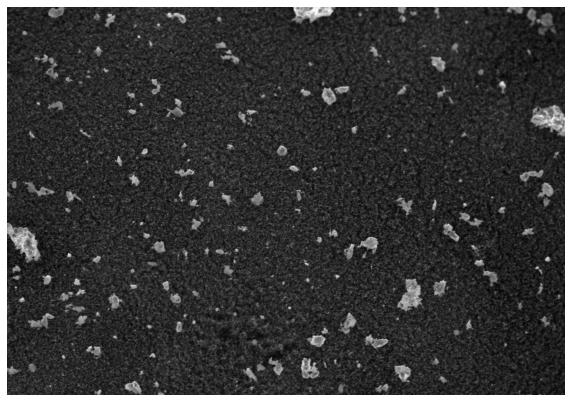

In [205]:
img,sem_dict = loadfile('/content/drive/MyDrive/CIOP/images/CUMP_GORA_i003.tif')

In [55]:
#pd.DataFrame(sem_dict,index=[0]).T

In [23]:
#image_info(img)

In [208]:
img2, median_img,mask = uniform(5,5)

Median Rectangle Box size: 356 x 512
Median intensity: 72.0
65.0
65.0


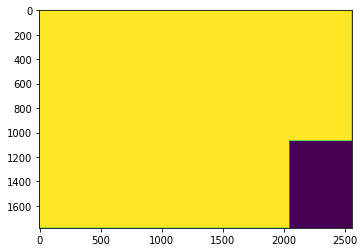

In [193]:
plt.imshow(mask)

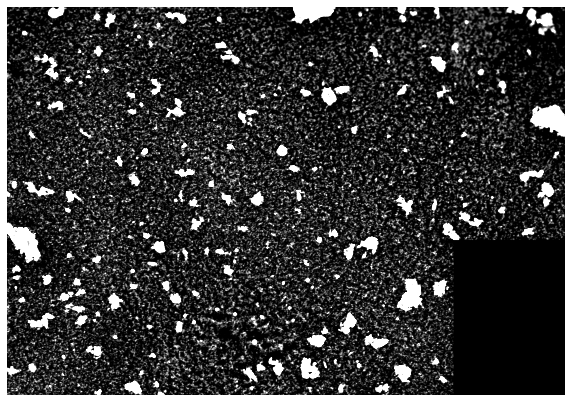

In [210]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=40, cmap='gray')
plt.show()

In [ ]:
#image_info(img2)

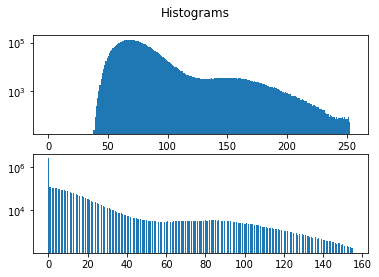

In [195]:
histograms()

50.0%, 100.0%, 

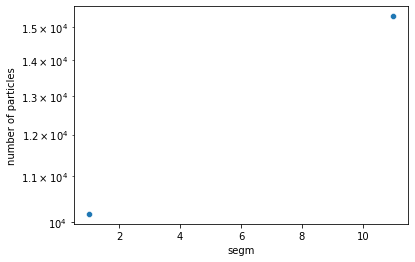

In [240]:
show_images = False
max_cutoff = 20
min_size = 10
step=10
do_fitting = True
particles = []
counter=0
if show_images and do_fitting:
    plt.imshow(img[1000:1500,500:1000],vmin=0,cmap='gray')
    plt.text(440,30,'img',backgroundcolor='white')
    plt.axis('off')
    plt.show()
if do_fitting:
    for i in range(1,max_cutoff+1,step):
        for j in range(1,min_size+1,step):
            counter+=1
            print(counter/((max_cutoff/step)*(min_size/step))*100, end = '%, ')
            img_segm = segmentation(i,6,j,1)
            img2_label, img2_label_overlay, data_nm = label_img()
            if show_images:
                plt.imshow(img_segm[1000:1500,500:1000],vmin=0,cmap='gray')
                plt.text(450,50,i,backgroundcolor='white')
                plt.axis('off')
                plt.show()
            particles.append([i,j,len(data_nm)])
    particles = pd.DataFrame(particles, columns=(['segm','low','number of particles']))
    sns.scatterplot(data=particles,x='segm',y='number of particles')
    plt.yscale('log')
    yinterp = np.interp(particles['segm'], particles['segm'], particles['number of particles'])

In [236]:
pd.pivot_table(particles,'number of particles', index='segm',columns='low')

low,1,11,21,31,41,51,61,71,81,91
segm,,,,,,,,,,
1,10175,5059,3884,3267,2859,2534,2285,2090,1943,1823
11,15346,6107,3985,2878,2194,1750,1418,1186,999,855
21,8911,2294,1159,723,539,423,341,296,261,234
31,3539,710,413,307,266,238,217,206,198,195
41,1336,348,260,241,224,208,195,188,183,174
51,640,276,240,222,208,193,185,176,176,173
61,404,254,227,210,195,186,180,176,173,169
71,368,259,235,211,199,190,180,175,165,157
81,415,280,236,211,196,190,176,168,158,155


In [213]:
img_segm = segmentation(30)

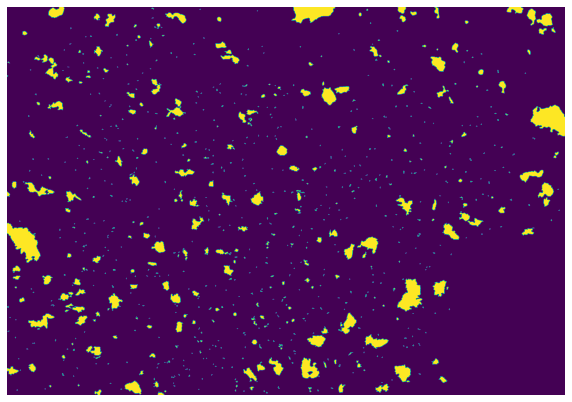

In [217]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm)
plt.show()

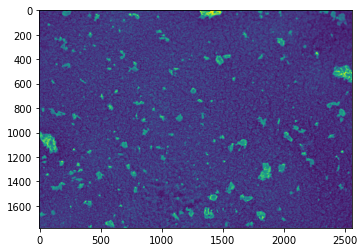

In [215]:
plt.imshow(img)

In [218]:
img2_label, img2_label_overlay, data_nm = label_img()

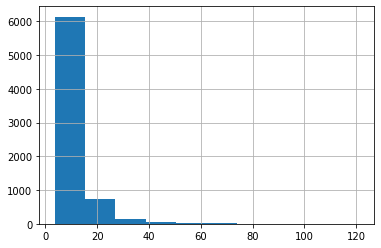

In [203]:
data_nm['equivalent_diameter'].hist()

In [219]:
bin_file_name = sem_dict['ImageName'].split('.')[0]+'_bin.png'
io.imsave(bin_file_name,img2_label_overlay)